In [3]:
import sys
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import os
import os.path
import sklearn
from umap import UMAP
from sklearn.decomposition import PCA, KernelPCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import mean_squared_error
from mpl_toolkits.basemap import Basemap

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


In [2]:
use_data_caching = True
keep_original_data_loaded = True
experiment = 'rcp26'

model_names = xr.open_dataset('./data/{0}/{0}_m6_tas_pr.nc'.format(experiment)).coords['model']

X_all_filename = './data/X_{}_all.npy'.format(experiment)
X_train_filename = './data/X_{}_train.npy'.format(experiment)
X_valid_filename = './data/X_{}_valid.npy'.format(experiment)
if use_data_caching and os.path.isfile(X_all_filename):
    print('loading cached data file {}'.format(X_all_filename))
    X_all = np.load(X_all_filename)
else:
    print('loading and processing dataset for experiment {}'.format(experiment))
    X_ds = xr.open_dataset('./data/{0}/{0}_m6_tas_pr.nc'.format(experiment))
    X_arr = X_ds.to_array().transpose('model', 'time', 'lat', 'lon', 'variable')
    X_all = X_arr.values
    nan_count = np.product(X_all.shape) - np.count_nonzero(~np.isnan(X_all))
    print('found {} NaN values in data'.format(nan_count))
    assert nan_count == 0
    # standardize variables
    for i in range(N_vars):
        stddev = np.std(X_all[:,:,:,:,i])
        X_all[:,:,:,:,i] = X_all[:,:,:,:,i] / stddev
    if use_data_caching:
        np.save(X_all_filename, X_all)
    
N_models, N_time, N_lat, N_lon, N_vars = X_all.shape
BATCH_SIZE = N_models*N_time / 20
    
N_models_train = N_models - 2
N_models_valid = N_models - N_models_train

if use_data_caching and os.path.isfile(X_train_filename):
    print('loading cached data file {}'.format(X_train_filename))
    X_train = np.load(X_train_filename)
else:
    print('generating training data')
    X_train = np.hstack(X_all[:N_models_train]).reshape((N_models_train*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_train_filename, X_train)

if use_data_caching and os.path.isfile(X_valid_filename):
    print('loading cached data file {}'.format(X_valid_filename))
    X_valid = np.load(X_valid_filename)
else:
    print('generating validation data')
    X_valid = np.hstack(X_all[N_models_train:]).reshape((N_models_valid*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_valid_filename, X_valid)

if not keep_original_data_loaded:
    del X_all
print('Loaded training data with shape: {}'.format(X_train.shape))
print('Loaded validation data with shape: {}'.format(X_valid.shape))

loading cached data file ./data/X_rcp26_all.npy
loading cached data file ./data/X_rcp26_train.npy
loading cached data file ./data/X_rcp26_valid.npy
Loaded training data with shape: (11520, 72, 144, 2)
Loaded validation data with shape: (5760, 72, 144, 2)


In [5]:
X_tr = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_vl = X_valid.reshape((X_valid.shape[0], np.prod(X_valid.shape[1:])))
target_dims = 18*36*1

In [3]:
pca = PCA(n_components=target_dims)
X_pca = pca.fit_transform(X_tr)

In [6]:
kpca = KernelPCA(n_components=target_dims, kernel='rbf', gamma=1.0E-3, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_tr)

In [15]:
rp = SparseRandomProjection(n_components=target_dims)
X_rp = rp.fit_transform(X_tr)

In [4]:
from sklearn.linear_model import Lasso

y = np.arange(0.0, X_tr.shape[0], 1.0)
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_pca, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [5]:
y_pred = lasso.predict(X_pca)
print(np.sqrt(mean_squared_error(y, y_pred)))

916.2686791846278


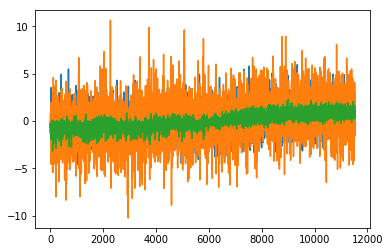

In [6]:
plt.plot(range(X_tr.shape[0]), X_tr[:,0])
plt.plot(range(X_tr.shape[0]), X_tr[:,1024])
plt.plot(range(X_tr.shape[0]), X_tr[:,4096])
plt.show()

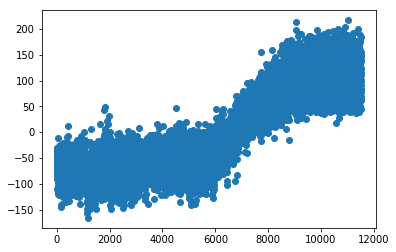

In [7]:
plt.scatter(range(X_tr.shape[0]), X_pca[:,0])

In [8]:
#X_vl_pca = pca.transform(X_vl)
#X_inv = pca.inverse_transform(X_vl_pca)
#print(mean_squared_error(X_vl, X_inv))

X_vl_kpca = kpca.transform(X_vl)
X_kinv = kpca.inverse_transform(X_vl_kpca)
print(mean_squared_error(X_vl, X_kinv))

1.0384032256687894


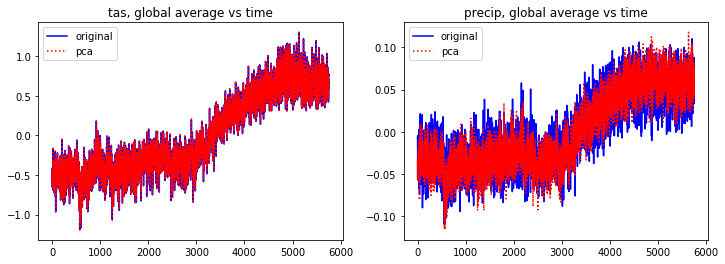

In [9]:
var = 0
X_vl_reshaped = np.reshape(X_vl, X_valid.shape)
X_inv_reshaped = np.reshape(X_inv, X_valid.shape)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(X_vl.shape[0]), np.mean(X_vl_reshaped, axis=(1,2))[:,var], c='blue')
plt.plot(range(X_vl.shape[0]), np.mean(X_inv_reshaped, axis=(1,2))[:,var], ':', c='red')
plt.title('tas, global average vs time')
plt.legend(['original', 'pca'])

var = 1
plt.subplot(1,2,2)
plt.plot(range(X_vl.shape[0]), np.mean(X_vl_reshaped, axis=(1,2))[:,var], c='blue')
plt.plot(range(X_vl.shape[0]), np.mean(X_inv_reshaped, axis=(1,2))[:,var], ':', c='red')
plt.title('precip, global average vs time')
plt.legend(['original', 'pca'])
plt.show()

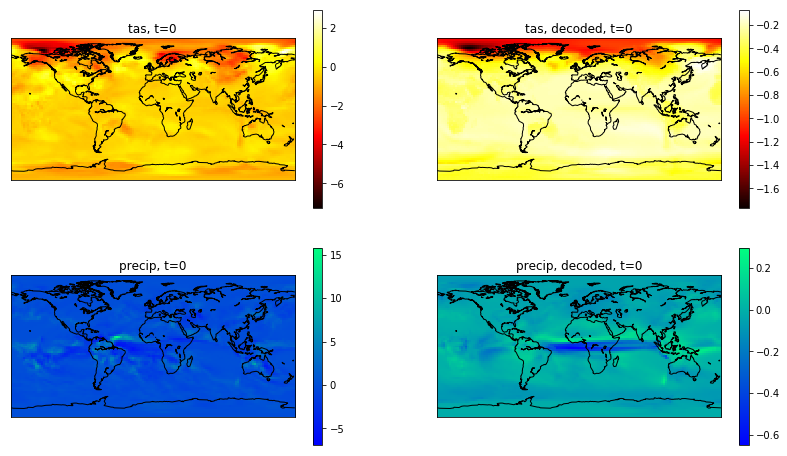

In [8]:
t = 0
c = 0
cmap = 'hot'
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
X_t = X_vl[t].reshape((72,144,2))
basemap = Basemap()
basemap.imshow(X_t[:,:,c], origin='lower', cmap=cmap)
plt.colorbar()
basemap.drawcoastlines()
plt.title('tas, t=0')
plt.subplot(2,2,2)
basemap.imshow(X_kinv[t].reshape((72,144,2))[:,:,c], origin='lower', cmap=cmap)
plt.colorbar()
basemap.drawcoastlines()
plt.title('tas, decoded, t=0')
c = 1
cmap = 'winter'
plt.subplot(2,2,3)
basemap.imshow(X_t[:,:,c], origin='lower', cmap=cmap)
plt.colorbar()
basemap.drawcoastlines()
plt.title('precip, t=0')
plt.subplot(2,2,4)
basemap.imshow(X_kinv[t].reshape((72,144,2))[:,:,c], origin='lower', cmap=cmap)
plt.colorbar()
plt.title('precip, decoded, t=0')
basemap.drawcoastlines()
plt.show()

In [46]:
from sklearn.manifold import TSNE

umap = UMAP(n_neighbors=10, min_dist=0.9)
timesteps = 360
X_pca_umap = umap.fit_transform(X_pca[:timesteps*N_models])

In [49]:
tsne = TSNE(perplexity=10, learning_rate=50)
X_pca_tsne = tsne.fit_transform(X_pca[:timesteps*N_models])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<xarray.DataArray 'model' (model: 6)>
array(['CCSM4', 'CESM1-CAM5', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MPI-ESM-LR'],
      dtype=object)
Coordinates:
  * model    (model) object 'CCSM4' 'CESM1-CAM5' ... 'MIROC5' 'MPI-ESM-LR'


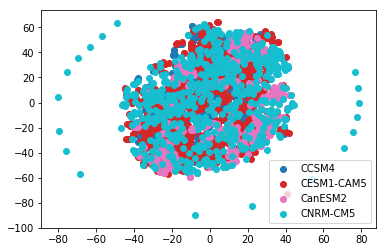

In [50]:
print(model_names)
ccsm4_timesteps = [i for i in range(0, timesteps*N_models, 4)]
cesm_timesteps = [i for i in range(1, timesteps*N_models, 4)]
canesm_timesteps = [i for i in range(2, timesteps*N_models, 4)]
cnrm_timesteps = [i for i in range(3, timesteps*N_models, 4)]
cmap = cm.get_cmap('tab10')
colors = [cmap(x) for x in np.linspace(0, 1, 4)]
X_target = X_pca_tsne
plt.scatter(X_target[ccsm4_timesteps,0], X_target[ccsm4_timesteps,1], c=colors[0])
plt.scatter(X_target[cesm_timesteps,0], X_target[cesm_timesteps,1], c=colors[1])
plt.scatter(X_target[canesm_timesteps,0], X_target[canesm_timesteps,1], c=colors[2])
plt.scatter(X_target[cnrm_timesteps,0], X_target[cnrm_timesteps,1], c=colors[3])
plt.legend(['CCSM4','CESM1-CAM5','CanESM2','CNRM-CM5'])
plt.show()